In [1]:
import pandas as pd
import sys
import os
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'SimHei'

### study the index future and its relationship to CSI 300 index

In [4]:
def read_idx_future():
    df_future =pd.read_csv('data/future_IF.csv', encoding="gb18030")
    df_future=df_future.rename(columns={'Unnamed: 0':'dealer'})
    df_future['datetime']=pd.to_datetime(df_future['datetime'], format='%Y%m%d')
    return df_future

def get_idx_future_top_traders(df_future, n):
    df_trader_vol= pd.DataFrame(df_future.groupby('dealer')['volume'].sum())
    df_trader_vol = df_trader_vol.sort_values(by='volume', ascending=False)
    return df_future[ df_future['dealer'].isin(df_trader_vol.index[:n])]

    df_trader_vol['volume'][n]
    

In [5]:
df_future= read_idx_future()
df_future_top=get_idx_future_top_traders(df_future,50)
print(df_future_top.info())

<class 'pandas.core.frame.DataFrame'>
Index: 32068 entries, 0 to 46302
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   dealer         32068 non-null  object        
 1   volume         32068 non-null  float64       
 2   volchange      32068 non-null  float64       
 3   buyvol         32068 non-null  float64       
 4   buyvolchange   32068 non-null  float64       
 5   sellvol        32068 non-null  float64       
 6   sellvolchange  32068 non-null  float64       
 7   net_vol_diff   32068 non-null  int64         
 8   datetime       32068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 2.4+ MB
None


In [18]:
import yfinance as yf
df_idx =yf.download('000300.SS', start='2021-01-04')
df_idx = df_idx.droplevel('Ticker',axis=1)
df_idx['next_day_ret'] =df_idx['Close'].pct_change().shift(-1)
print(df_idx.head())

C:\Users\mingl\AppData\Local\Temp\ipykernel_4920\387751730.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_idx =yf.download('000300.SS', start='2021-01-04')
[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open  Volume  \
Date                                                                     
2021-03-11  5128.220215  5138.410156  5020.580078  5024.560059  189600   
2021-03-12  5146.379883  5153.669922  5086.819824  5153.669922  201000   
2021-03-15  5035.540039  5120.879883  4992.399902  5116.120117  204200   
2021-03-16  5079.359863  5084.310059  5009.950195  5054.410156  161400   
2021-03-17  5100.859863  5123.549805  5020.129883  5062.770020  149200   

Price       next_day_ret  
Date                      
2021-03-11      0.003541  
2021-03-12     -0.021537  
2021-03-15      0.008702  
2021-03-16      0.004233  
2021-03-17      0.008020  


### check out if the net-future-vol is correlated to the next day's sp_idx

In [7]:
import math
def cal_corr(df_idx, df_future):
    df_future_net_vol=df_future.groupby('datetime')['net_vol_diff'].sum()
    df_future_net_vol=pd.DataFrame(df_future_net_vol)
    df_future_net_vol.index =pd.to_datetime(df_future_net_vol.index, format='%Y%m%d')
    df_future_net_vol['last_net_future_vol'] =df_future_net_vol['net_vol_diff'].shift(1)
    return df_idx['Close'].corr(df_future_net_vol['last_net_future_vol'])

df_corr =pd.DataFrame(columns=['dealer', 'correlation'])
#print(cal_corr(df_idx,df_future))
df_corr.loc[len(df_corr)] ={'dealer':'all', 'correlation':cal_corr(df_idx,df_future)}

for dealer in df_future_top['dealer'].unique():
    df_future_by_dealer=df_future[df_future['dealer']==dealer].copy()
    df_future_by_dealer.dropna(inplace=True)
    
    df_corr.loc[len(df_corr)] ={'dealer':dealer, 'correlation':cal_corr(df_idx,df_future_by_dealer)}

df_corr['abs_correlation'] =abs(df_corr['correlation'])
print(df_corr)

      dealer  correlation  abs_correlation
0        all     0.105648         0.105648
1       一德期货     0.007622         0.007622
2       上海东证    -0.016096         0.016096
3       东兴期货     0.075958         0.075958
4       中信建投     0.027979         0.027979
5       中信期货     0.033532         0.033532
6       中金期货     0.033352         0.033352
7       五矿经易    -0.113103         0.113103
8       光大期货    -0.003351         0.003351
9       兴证期货     0.004693         0.004693
10      华泰期货     0.018167         0.018167
11      华西期货    -0.012067         0.012067
12      华闻期货     0.123213         0.123213
13      南华期货     0.001741         0.001741
14      国信期货    -0.015223         0.015223
15      国富期货    -0.004155         0.004155
16      国投安信     0.077051         0.077051
17      国泰君安    -0.062369         0.062369
18      平安期货    -0.025382         0.025382
19      广发期货     0.012736         0.012736
20      招商期货     0.011005         0.011005
21      方正中期     0.003144         0.003144
22      永安期

C:\Users\mingl\AppData\Local\Temp\ipykernel_4920\1325618401.py:6: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.tight_layout()
d:\PythonEnvs\qlib\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


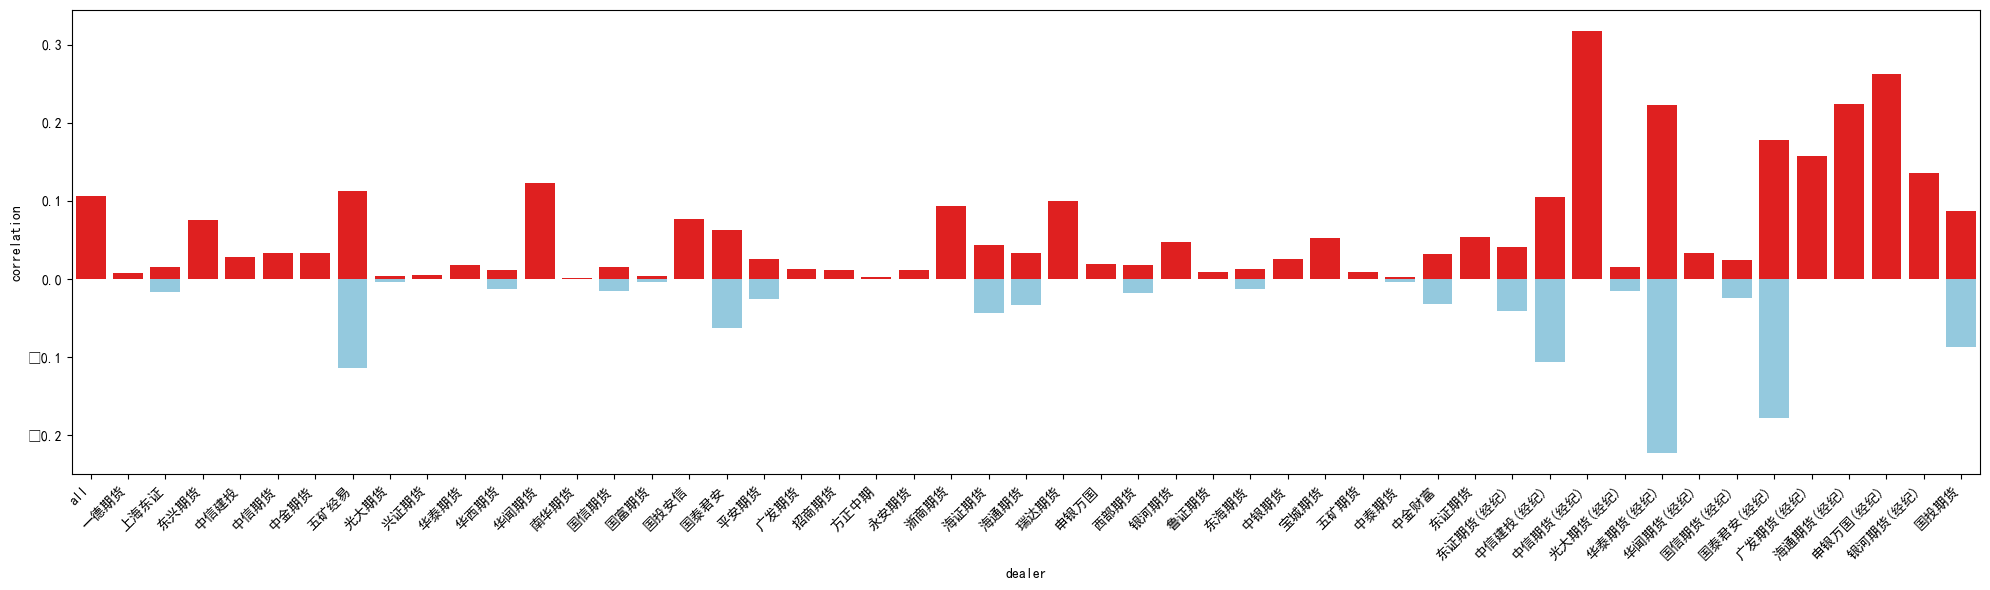

In [8]:

plt.figure(figsize=(20, 6))
sns.barplot(data=df_corr, x='dealer', y='correlation', color='skyblue')
sns.barplot(data=df_corr, x='dealer', y='abs_correlation', color='red')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [11]:
print(df_future_top.head())

  dealer   volume  volchange   buyvol  buyvolchange  sellvol  sellvolchange  \
0   一德期货   1244.0       71.0  10270.0        -220.0      0.0            0.0   
1   上海东证  11453.0     1641.0   6165.0        -174.0  20206.0         -173.0   
3   东兴期货   6661.0     -748.0   2287.0         -74.0   1737.0          -32.0   
5   中信建投   2789.0     -521.0   1530.0        -235.0   5910.0         -266.0   
6   中信期货  17629.0    -1963.0  14846.0        -922.0  26386.0        -1033.0   

   net_vol_diff   datetime  
0          -220 2021-01-04  
1            -1 2021-01-04  
3           -42 2021-01-04  
5            31 2021-01-04  
6           111 2021-01-04  


In [25]:
df_future_pivot=df_future_top.pivot(index='datetime', columns='dealer', values='net_vol_diff')
df_future_pivot=df_future_pivot.fillna(0)

In [30]:
df_idx_with_future_trades =df_idx.merge(df_future_pivot, left_index=True, right_index=True, how='outer')
df_idx_with_future_trades.dropna(inplace=True)


In [31]:
print(df_idx_with_future_trades.tail(1))

                  Close        High          Low         Open    Volume  \
2025-06-20  3846.639893  3856.47998  3839.780029  3839.780029  118200.0   

            next_day_ret   一德期货  上海东证  东兴期货  东海期货  ...  海证期货   海通期货  海通期货(经纪)  \
2025-06-20     -0.002149 -106.0   0.0   0.0   7.0  ...   0.0 -133.0       0.0   

            瑞达期货   申银万国  申银万国(经纪)  西部期货   银河期货  银河期货(经纪)  鲁证期货  
2025-06-20   0.0 -618.0       0.0   0.0  157.0       0.0   0.0  

[1 rows x 56 columns]


### do ML/AI

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml

In [45]:

X= df_idx_with_future_trades.drop(columns=['next_day_ret','Close','High','Low','Open','Volume'])
y=df_idx_with_future_trades['next_day_ret']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
print(X_train.head())

             一德期货    上海东证  东兴期货  东海期货   东证期货  东证期货(经纪)   中信建投  中信建投(经纪)  \
2024-07-08    0.0     0.0   0.0  -1.0  358.0       0.0   -5.0       0.0   
2023-01-06  243.0  -336.0 -83.0  91.0    0.0       0.0   -9.0       0.0   
2021-08-19   13.0   571.0  98.0   0.0    0.0       0.0 -183.0       0.0   
2025-01-14  208.0     0.0   0.0  35.0  223.0       0.0  -34.0       0.0   
2022-08-26   15.0  1412.0  23.0   0.0    0.0       0.0   -3.0       0.0   

             中信期货  中信期货(经纪)  ...   海证期货   海通期货  海通期货(经纪)   瑞达期货   申银万国  \
2024-07-08  271.0       0.0  ...    0.0   88.0       0.0    0.0 -308.0   
2023-01-06 -411.0       0.0  ...    0.0 -141.0       0.0    0.0  411.0   
2021-08-19  -87.0       0.0  ...  332.0  285.0       0.0  105.0  -79.0   
2025-01-14 -823.0       0.0  ...    0.0 -435.0       0.0    0.0  131.0   
2022-08-26  217.0       0.0  ...    0.0 -135.0       0.0    0.0  233.0   

            申银万国(经纪)  西部期货   银河期货  银河期货(经纪)   鲁证期货  
2024-07-08       0.0   0.0  234.0       0.0    0.0 

In [47]:
print(y_train)

2024-07-08    0.011185
2023-01-06    0.008096
2021-08-19   -0.019101
2025-01-14   -0.006415
2022-08-26   -0.004389
                ...   
2021-07-19   -0.000880
2022-07-20   -0.011144
2023-02-13    0.000415
2021-09-03    0.018722
2024-09-24    0.014804
Name: next_day_ret, Length: 829, dtype: float64


In [48]:
models = {
    'LinearRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LinearRegression())]),

    'RidgeRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge())]),
    'KnnRegressor': Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsRegressor())]),
    'DecisionTreeRegressor': Pipeline([
        ('scaler', StandardScaler()),
        ('dt', DecisionTreeRegressor())]),
    'SupportVectorRegressor': Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR())]),
    'TransformedTargetRegressor': TransformedTargetRegressor(
        regressor=LinearRegression(),
        transformer=StandardScaler()
    ),
    
}

In [54]:
df_score = pd.DataFrame(columns=['Model', 'MSE'])
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name}: {mse:.8f}")
    df_score.loc[len(df_score)] = {'Model': name, 'MSE': mse}

LinearRegression: 0.00013800
RidgeRegression: 0.00013790
KnnRegressor: 0.00012377
DecisionTreeRegressor: 0.00025099
SupportVectorRegressor: 0.00016893
TransformedTargetRegressor: 0.00013800


In [56]:
voter = VotingRegressor(
    estimators=[(name, model) for name, model in models.items()]
)
voter.fit(X_train, y_train)
y_pred = voter.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

df_score.loc[len(df_score)] = {'Model': 'VotingRegressor', 'MSE': mse}


In [57]:
print(df_score)

                        Model       MSE
0            LinearRegression  0.000138
1             RidgeRegression  0.000138
2                KnnRegressor  0.000124
3       DecisionTreeRegressor  0.000251
4      SupportVectorRegressor  0.000169
5  TransformedTargetRegressor  0.000138
6             VotingRegressor  0.000129
7             VotingRegressor  0.000131


In [ ]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
param_grid = {
    'LinearRegression__lr__fit_intercept': [True, False],
    'RidgeRegression__ridge__alpha': [0.1, 1.0, 10.0],
    'RidgeRegression__ridge__fit_intercept': [True, False],
    'KnnRegressor__knn__n_neighbors': [3, 5, 7],
    'KnnRegressor__knn__weights': ['uniform', 'distance'],
    'DecisionTreeRegressor__dt__max_depth': [None, 5, 10],
    'DecisionTreeRegressor__dt__min_samples_split': [2, 5],
    'SupportVectorRegressor__svr__C': [0.1, 1.0, 10.0],
    'SupportVectorRegressor__svr__kernel': ['rbf', 'linear'],
    'SupportVectorRegressor__svr__epsilon': [0.1, 0.2],
    'TransformedTargetRegressor__regressor__fit_intercept': [True, False],
    'TransformedTargetRegressor__transformer': [StandardScaler(), PowerTransformer(method='yeo-johnson'), None],

    #'weights': [[1, 1, 1, 1, 1], [2, 1, 1, 1, 1], [1, 2, 1, 1, 1], [1, 1, 2, 1, 1], [1, 1, 1, 2, 1], [1, 1, 1, 1, 2]]
}
grid_search = GridSearchCV(
        estimator=voter,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
grid_search.fit(X_train, y_train)
results = {
    'best_score': grid_search.best_score_,
    'best_params': grid_search.best_params_,
    'best_estimator': grid_search.best_estimator_
}
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits
Best parameters: {'DecisionTreeRegressor__dt__max_depth': 5, 'DecisionTreeRegressor__dt__min_samples_split': 2, 'KnnRegressor__knn__n_neighbors': 7, 'KnnRegressor__knn__weights': 'uniform', 'LinearRegression__lr__fit_intercept': False, 'RidgeRegression__ridge__alpha': 1.0, 'RidgeRegression__ridge__fit_intercept': True, 'SupportVectorRegressor__svr__C': 1.0, 'SupportVectorRegressor__svr__epsilon': 0.1, 'SupportVectorRegressor__svr__kernel': 'rbf'}
Best score: -0.00013960148122517442
